# Demo of Lambert W x F distributions in torch

This notebook illustrates the implementation of the Lambert W x F distributions using `torch` and `torch.distributions.Distribution` objects.

This is based on work in 


Goerg (2011). Lambert W random variables—a new family of generalized skewed distributions with applications to risk estimation. Ann. Appl. Stat. 5 (3) 2197 - 2230, 2011. https://doi.org/10.1214/11-AOAS457

Goerg (2015) The Lambert Way to Gaussianize Heavy-Tailed Data with the Inverse of Tukey’s h Transformation as a Special Case. The Scientific World Journal. Volume 2015 | Article ID 909231 | https://doi.org/10.1155/2015/909231


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Only run if not already on PYTHONPATH / venv
import os
import sys
import pathlib
from os.path import dirname
parent_path = dirname(pathlib.Path(pathlib.Path(os.getcwd())))

if parent_path not in sys.path:
    sys.path.insert(0, parent_path)

In [9]:
import torch
import scipy.special
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# import module for demo
import torchlambertw as tlw
import torchlambertw.special
from torchlambertw import distributions as tlwd
from torchlambertw.utils import plot as twplt

/home/georg/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/home/georg/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


## Lambert W x Gaussian


Here is an illustration of a heavy-tail Lambert W x Gaussian distribution, which takes a Gaussian input and turns it into something heavy-tailed. If `tailweight = 0` then its just a Gaussian again.


In [4]:
# Use a slightly heavy-tailed distribution with a tail parameter of 0.25 (ie moments < 1/0.25 = 4 exist).
m = tlwd.TailLambertWNormal(loc=torch.tensor([1.0]), scale=torch.tensor([3.0]), 
                            tailweight=torch.tensor([0.25]))
m, type(m), isinstance(m, torch.distributions.Distribution)

(TailLambertWNormal(tailweight: tensor([0.2500])),
 torchlambertw.distributions.TailLambertWNormal,
 True)

This is a `torch.distributions.Distributions` object; thus it has all the usual supported methods of distributions like sampling (`.sample()`), probability evaluation (`.log_prob()`), and moments (`.mean`, `.mode`, `.variance`, ...)

In [5]:
torch.manual_seed(0)
m.sample((2,)) 

tensor([[7.2207],
        [0.1102]])

In [6]:
print(m.tailweight, m.support, m.mean, m.variance)

tensor([0.2500]) Real() tensor([1.]) tensor([25.4558])


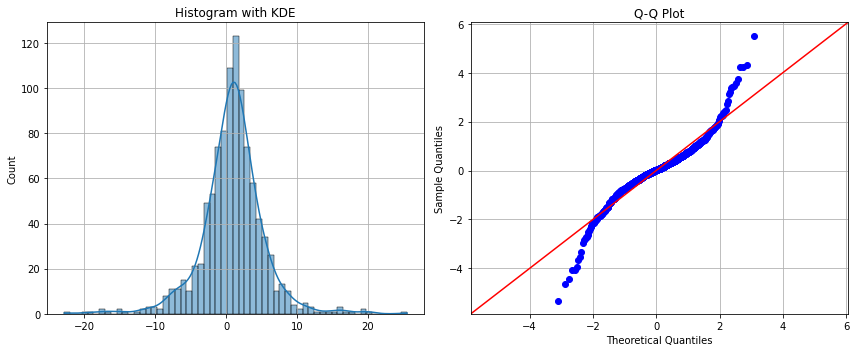

In [11]:
y = m.sample((1000,)).numpy().ravel()
twplt.test_norm(y)

,loglik
normal,-2915.264160
normal_again,-2915.264160
lambertw_normal,-2804.008545


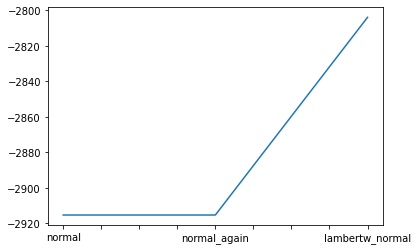

In [12]:
# assume its normal and eval likelihood
norm = torch.distributions.Normal(loc=y.mean(), scale=y.std())
# Set tailweight = 0 ('delta' in the papers), then a Lambert W x Normal is identical to Normal
norm_again = tlwd.TailLambertWNormal(loc=y.mean(), scale=y.std(), tailweight=0.0)

# Compare likelihood of all three distributions; since data was generated from `m`, should have highest likelihood.
def _loglik(dist, data):
    return dist.log_prob(torch.tensor(data)).sum().numpy().ravel()[0]
                         
total_logliks = pd.Series(
    {"normal": _loglik(norm, y),
     "normal_again": _loglik(norm_again, y),
     "lambertw_normal": _loglik(m, y)})
total_logliks.plot()
total_logliks.to_frame("loglik")


# Skewed Lambert W x F distributions

For introducting skewness one can use the skewed Lambert W x F distributions; particularly
interesting are skewed Lambert W x Gaussian distributions as they can be used to transform Normal data to skewed data (and back).

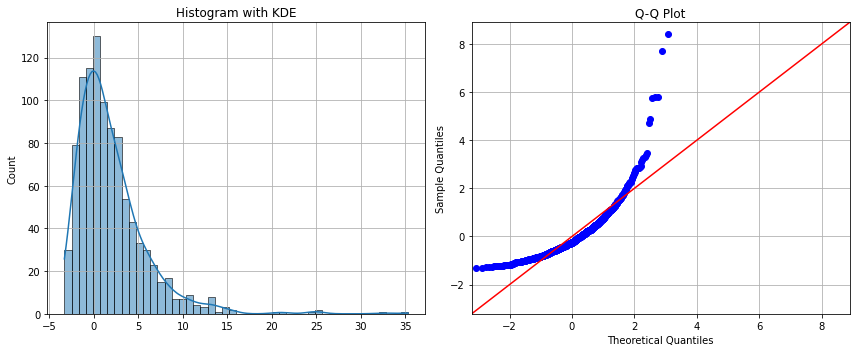

In [13]:
torch.manual_seed(0)
m = tlwd.SkewLambertWNormal(loc=torch.tensor([1.0]), scale=torch.tensor([3.0]), 
                        skewweight=torch.tensor([0.25]))
y = m.sample((1000,)).numpy().ravel()

twplt.test_norm(y)

## Skewed Lambert W x Exponential distributions

Lambert W x F distribution can be generated for any arbitratry F.  Here we show an example of a skewed Lambert W x Exponential distribution. For `skewweight > 0` , this will be more (right) skewed than a baseline exponential distribution. 

See Goerg (2011) and Kaarik et al. (2023).

In [14]:
torch.manual_seed(0)
m = tlwd.SkewLambertWExponential(rate=torch.tensor([3.0]), 
                                 skewweight=torch.tensor([0.2]))
y = m.sample((1000,)).numpy().ravel()
print("mean: theoretical %f; empirical: %f" % (m.mean.numpy()[0], np.mean(y)))

mean: theoretical 0.520833; empirical: 0.481116


Mean is larger than the 1/3. rate of the baseline exponential distribution because of the longer tail, which is also clearly visible in density chart and qqplot.

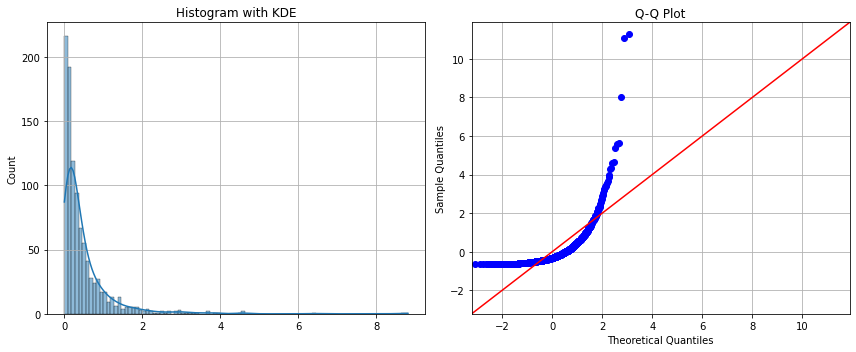

In [15]:
twplt.test_norm(y)

## WIP: estimate gaussianizing transformations based on estimated parametres

**IMPORTANT**: module names / hierarchy, class names, methods, return values etc will (!) change. This is for testing purposes.

In [36]:
# Use a slightly heavy-tailed distribution with a tail parameter of 0.25 (ie moments < 1/0.25 = 4 exist).
torch.manual_seed(0)

m = tlwd.TailLambertWNormal(loc=torch.tensor([1.0]), scale=torch.tensor([3.0]), 
                            tailweight=torch.tensor([0.5]))
y = m.sample((1000,)).numpy().ravel()

In [45]:
import torchlambertw.models.igmm

In [47]:
import torchlambertw.models.mle

import importlib
importlib.reload(torchlambertw.models.mle)
clf = torchlambertw.models.mle.MLE("normal", verbose=0)
clf.fit(y)

MLE(dist_name='normal')

<AxesSubplot:>

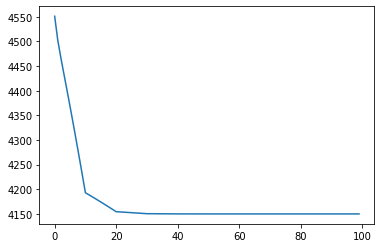

In [48]:
pd.Series(clf.losses).plot()

In [49]:
from torchlambertw.preprocessing import gaussianizing
data = y
clf = gaussianizing.Gaussianizer("h", method="mle")
clf.fit(data)
clf.estimators

{0: MLE(dist_name='normal')}

In [50]:
clf.estimator[0].params_

Theta(beta={'loc': 1.1375982761383057, 'scale': 21.96833914443934}, gamma=0.0, delta=0.1541007592947767, alpha=1.0)

In [51]:
#test_norm(y)

In [52]:
pd.Series(clf.transform(y)).describe()

count    1000.000000
mean             inf
std              NaN
min      -900.656311
25%        -1.063861
50%         0.956125
75%         3.342346
max              inf
dtype: float64